# Basic engine implementation

#### setup

In [ ]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"


#### Detecting the face landmarks and parsiong the ROI

In [36]:
def parse_roi(frame):
    image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(image) # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)

    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.open(frame)
        top,right,bottom,left = face_location # extract all face squre points.
        diff = math.floor((top - bottom) * 0.2) # 30 percent of the face len (toadd eyebrow top point).
        # Finding the forhead.
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom)) # adding diff to top to make the forehead bigger.

        # Finging the second ROI:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))
        try:
            concat_roi_areas = np.concatenate((forehead, nose_to_upper_lip), axis=0)
            cv2.imwrite('frame_roi_output.jpg', concat_roi_areas)
        except:
            logging.warning("concat of roi areas failed")

#### Getting RGB values from a frame and adding them to arrays

In [37]:
def parse_RGB(image, vidcap, greens, reds, blues, frame_number):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    blue, green, red = cv2.split(image)
    greens[0, frame_number] = np.mean(green)
    blues[0, frame_number] = np.mean(blue)
    reds[0, frame_number] = np.mean(red)
    success, image = vidcap.read()
    return success, image

#### Plotting RGB arrays results

In [38]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    x_value = x_value.reshape(1, x_value.shape[0])
    r = reds.tolist()[0]
    b = blues.tolist()[0]
    g = greens.tolist()[0]
    x = x_value.tolist()[0]
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x, g, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x, r, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x, b, color="blue")
    plt.show()
    logging.info("Showing result")

#### Main loop - going over all the frames of the video

[2021-03-09 18:57:12,578] [INFO] [<module>] [1] : Working on video ..\dataset\good_sync\perry-all-2\test.mp4
[2021-03-09 18:57:12,643] [INFO] [<module>] [11] : Parsing images ...
[2021-03-09 18:57:12,644] [INFO] [<module>] [13] : parsing frame 0/810.0
[2021-03-09 18:57:13,792] [INFO] [<module>] [13] : parsing frame 1/810.0
[2021-03-09 18:57:14,937] [INFO] [<module>] [13] : parsing frame 2/810.0
[2021-03-09 18:57:16,067] [INFO] [<module>] [13] : parsing frame 3/810.0
[2021-03-09 18:57:17,245] [INFO] [<module>] [13] : parsing frame 4/810.0
[2021-03-09 18:57:18,458] [INFO] [<module>] [13] : parsing frame 5/810.0
[2021-03-09 18:57:19,618] [INFO] [<module>] [13] : parsing frame 6/810.0
[2021-03-09 18:57:20,802] [INFO] [<module>] [13] : parsing frame 7/810.0
[2021-03-09 18:57:22,029] [INFO] [<module>] [13] : parsing frame 8/810.0
[2021-03-09 18:57:23,234] [INFO] [<module>] [13] : parsing frame 9/810.0
[2021-03-09 18:57:24,441] [INFO] [<module>] [13] : parsing frame 10/810.0
[2021-03-09 18:57

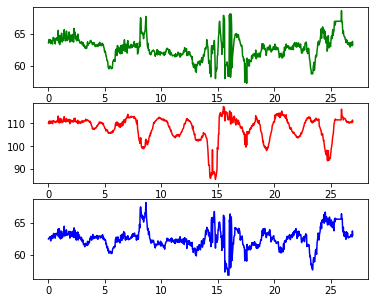

In [39]:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
x_value = np.arange((number_of_frames / np.round(fps)), step=(1 / 30))
greens = np.zeros((1, int(number_of_frames)))  # instead of lists
reds = np.zeros((1, int(number_of_frames)))
blues = np.zeros((1, int(number_of_frames)))
frame_number = 0
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(frame_number) + "/" + str(number_of_frames))
    im = Image.fromarray(image)
    im.save("your_file.jpeg")
    parse_roi("your_file.jpeg")  # build image ROI
    image = cv2.imread("frame_roi_output.jpg") # possible BUG: read the same image twice if face not detected.
    success, image = parse_RGB(image, vidcap, greens, reds, blues, frame_number)
    frame_number += 1
plot_result(greens, reds, blues, x_value, "All 3 channels") # original signals